**Voice Activity Detection**

In [31]:


import os
import math
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.special import jv

def bessel(v, X):
    return ((1j ** (-v)) * jv(v, 1j * X)).real


def stft(x, n_fft=512, win_length=400, hop_length=160, window='hamming'):
    if window == 'hanning':
        window = np.hanning(win_length)
    elif window == 'hamming':
        window = np.hamming(win_length)
    elif window == 'rectangle':
        window = np.ones(win_length)
    return np.array(
        [np.fft.rfft(window * x[i:i + win_length], n_fft, axis=0) for i in range(0, len(x) - win_length, hop_length)])


def estnoisem(pSpectrum, hop_length):
    (nFrames, nFFT2) = np.shape(pSpectrum)  # number of frames and freq bins
    x = np.array(np.zeros((nFrames, nFFT2)))  # initialize output arrays
    xs = np.array(np.zeros((nFrames, nFFT2)))  # will hold std error in the future

    # default algorithm constants
    taca = 0.0449  # smoothing time constant for alpha_c = -hop_length/log(0.7) in equ (11)
    tamax = 0.392  # max smoothing time constant in (3) = -hop_length/log(0.96)
    taminh = 0.0133  # min smoothing time constant (upper limit) in (3) = -hop_length/log(0.3)
    tpfall = 0.064  # time constant for P to fall (12)
    tbmax = 0.0717  # max smoothing time constant in (20) = -hop_length/log(0.8)
    qeqmin = 2.0  # minimum value of Qeq (23)
    qeqmax = 14.0  # max value of Qeq per frame
    av = 2.12  # fudge factor for bc calculation (23 + 13 lines)
    td = 1.536  # time to take minimum over
    nu = 8  # number of subwindows
    qith = np.array([0.03, 0.05, 0.06, np.Inf], dtype=float)  # noise slope thresholds in dB/s
    nsmdb = np.array([47, 31.4, 15.7, 4.1], dtype=float)  # maximum permitted +ve noise slope in dB/s

    # derived algorithm constants
    aca = np.exp(-hop_length / taca)  # smoothing constant for alpha_c in equ (11) = 0.7
    acmax = aca  # min value of alpha_c = 0.7 in equ (11) also = 0.7
    amax = np.exp(-hop_length / tamax)  # max smoothing constant in (3) = 0.96
    aminh = np.exp(-hop_length / taminh)  # min smoothing constant (upper limit) in (3) = 0.3
    bmax = np.exp(-hop_length / tbmax)  # max smoothing constant in (20) = 0.8
    SNRexp = -hop_length / tpfall
    nv = round(td / (hop_length * nu))  # length of each subwindow in frames

    if nv < 4:  # algorithm doesn't work for miniscule frames
        nv = 4
        nu = round(td / (hop_length * nv))
    nd = nu * nv  # length of total window in frames
    (md, hd, dd) = mhvals(nd)  # calculate the constants M(D) and H(D) from Table III
    (mv, hv, dv) = mhvals(nv)  # calculate the constants M(D) and H(D) from Table III
    nsms = np.array([10]) ** (nsmdb * nv * hop_length / 10)  # [8 4 2 1.2] in paper
    qeqimax = 1 / qeqmin  # maximum value of Qeq inverse (23)
    qeqimin = 1 / qeqmax  # minumum value of Qeq per frame inverse

    p = pSpectrum[0, :]  # smoothed power spectrum
    ac = 1  # correction factor (9)
    sn2 = p  # estimated noise power
    pb = p  # smoothed noisy speech power (20)
    pb2 = pb ** 2
    pminu = p
    actmin = np.array(np.ones(nFFT2) * np.Inf)  # Running minimum estimate
    actminsub = np.array(np.ones(nFFT2) * np.Inf)  # sub-window minimum estimate
    subwc = nv  # force a buffer switch on first loop
    actbuf = np.array(np.ones((nu, nFFT2)) * np.Inf)  # buffer to store subwindow minima
    ibuf = 0
    lminflag = np.zeros(nFFT2)  # flag to remember local minimum

    # loop for each frame
    for t in range(0, nFrames):  # we use t instead of lambda in the paper
        pSpectrum_t = pSpectrum[t, :]  # noise speech power spectrum
        acb = (1 + (sum(p) / sum(pSpectrum_t) - 1) ** 2) ** (-1)  # alpha_c-bar(t)  (9)

        tmp = np.array([acb])
        tmp[tmp < acmax] = acmax
        # max_complex(np.array([acb] ),np.array([acmax] ))
        ac = aca * ac + (1 - aca) * tmp  # alpha_c(t)  (10)
        ah = amax * ac * (1 + (p / sn2 - 1) ** 2) ** (-1)  # alpha_hat: smoothing factor per frequency (11)
        SNR = sum(p) / sum(sn2)
        ah = max_complex(ah,
                         min_complex(np.array([aminh]), np.array([SNR ** SNRexp])))  # lower limit for alpha_hat (12)
        p = ah * p + (1 - ah) * pSpectrum_t  # smoothed noisy speech power (3)
        b = min_complex(ah ** 2,
                        np.array([bmax]))  # smoothing constant for estimating periodogram variance (22 + 2 lines)
        pb = b * pb + (1 - b) * p  # smoothed periodogram (20)
        pb2 = b * pb2 + (1 - b) * p ** 2  # smoothed periodogram squared (21)
        qeqi = max_complex(min_complex((pb2 - pb ** 2) / (2 * sn2 ** 2), np.array([qeqimax])),
                           np.array([qeqimin / (t + 1)]))  # Qeq inverse (23)
        qiav = sum(
            qeqi) / nFFT2  # Average over all frequencies (23+12 lines) (ignore non-duplication of DC and nyquist terms)
        bc = 1 + av * np.sqrt(qiav)  # bias correction factor (23+11 lines)
        bmind = 1 + 2 * (nd - 1) * (1 - md) / (
                    qeqi ** (-1) - 2 * md)  # we use the signalmplified form (17) instead of (15)
        bminv = 1 + 2 * (nv - 1) * (1 - mv) / (qeqi ** (-1) - 2 * mv)  # same expressignalon but for sub windows
        kmod = (bc * p * bmind) < actmin  # Frequency mask for new minimum

        if any(kmod):
            actmin[kmod] = bc * p[kmod] * bmind[kmod]
            actminsub[kmod] = bc * p[kmod] * bminv[kmod]

        if subwc > 1 and subwc < nv:  # middle of buffer - allow a local minimum
            lminflag = np.logical_or(lminflag, kmod)  # potential local minimum frequency bins
            pminu = min_complex(actminsub, pminu)
            sn2 = pminu.copy()
        else:
            if subwc >= nv:  # end of buffer - do a buffer switch
                ibuf = 1 + (ibuf % nu)  # increment actbuf storage pointer
                actbuf[ibuf - 1, :] = actmin.copy()  # save sub-window minimum
                pminu = min_complex_mat(actbuf)
                i = np.nonzero(np.array(qiav) < qith)
                nsm = nsms[i[0][0]]  # noise slope max
                lmin = np.logical_and(
                    np.logical_and(np.logical_and(lminflag, np.logical_not(kmod)), actminsub < (nsm * pminu)),
                    actminsub > pminu)
                if any(lmin):
                    pminu[lmin] = actminsub[lmin]
                    actbuf[:, lmin] = np.ones((nu, 1)) * pminu[lmin]
                lminflag[:] = 0
                actmin[:] = np.Inf
                subwc = 0
        subwc = subwc + 1
        x[t, :] = sn2.copy()
        qisq = np.sqrt(qeqi)
        # empirical formula for standard error based on Fig 15 of [2]
        xs[t, :] = sn2 * np.sqrt(
            0.266 * (nd + 100 * qisq) * qisq / (1 + 0.005 * nd + 6 / nd) / (0.5 * qeqi ** (-1) + nd - 1))

    return x


def mhvals(*args):
    nargin = len(args)

    dmh = np.array([
        [1, 0, 0],
        [2, 0.26, 0.15],
        [5, 0.48, 0.48],
        [8, 0.58, 0.78],
        [10, 0.61, 0.98],
        [15, 0.668, 1.55],
        [20, 0.705, 2],
        [30, 0.762, 2.3],
        [40, 0.8, 2.52],
        [60, 0.841, 3.1],
        [80, 0.865, 3.38],
        [120, 0.89, 4.15],
        [140, 0.9, 4.35],
        [160, 0.91, 4.25],
        [180, 0.92, 3.9],
        [220, 0.93, 4.1],
        [260, 0.935, 4.7],
        [300, 0.94, 5]
    ], dtype=float)

    if nargin >= 1:
        d = args[0]
        i = np.nonzero(d <= dmh[:, 0])
        if len(i) == 0:
            i = np.shape(dmh)[0] - 1
            j = i
        else:
            i = i[0][0]
            j = i - 1
        if d == dmh[i, 0]:
            m = dmh[i, 1]
            h = dmh[i, 2]
        else:
            qj = np.sqrt(dmh[i - 1, 0])  # interpolate usignalng sqrt(d)
            qi = np.sqrt(dmh[i, 0])
            q = np.sqrt(d)
            h = dmh[i, 2] + (q - qi) * (dmh[j, 2] - dmh[i, 2]) / (qj - qi)
            m = dmh[i, 1] + (qi * qj / q - qj) * (dmh[j, 1] - dmh[i, 1]) / (qi - qj)
    else:
        d = dmh[:, 0].copy()
        m = dmh[:, 1].copy()
        h = dmh[:, 2].copy()

    return m, h, d


def max_complex(a, b):
    if len(a) == 1 and len(b) > 1:
        a = np.tile(a, np.shape(b))
    if len(b) == 1 and len(a) > 1:
        b = np.tile(b, np.shape(a))

    i = np.logical_or(np.iscomplex(a), np.iscomplex(b))

    aa = a.copy()
    bb = b.copy()

    if any(i):
        aa[i] = np.absolute(aa[i])
        bb[i] = np.absolute(bb[i])
    if a.dtype == 'complex' or b.dtype == 'complex':
        cc = np.array(np.zeros(np.shape(a)))
    else:
        cc = np.array(np.zeros(np.shape(a)), dtype=float)

    i = aa > bb
    cc[i] = a[i]
    cc[np.logical_not(i)] = b[np.logical_not(i)]

    return cc


def min_complex(a, b):

    if len(a) == 1 and len(b) > 1:
        a = np.tile(a, np.shape(b))
    if len(b) == 1 and len(a) > 1:
        b = np.tile(b, np.shape(a))

    i = np.logical_or(np.iscomplex(a), np.iscomplex(b))

    aa = a.copy()
    bb = b.copy()

    if any(i):
        aa[i] = np.absolute(aa[i])
        bb[i] = np.absolute(bb[i])

    if a.dtype == 'complex' or b.dtype == 'complex':
        cc = np.array(np.zeros(np.shape(a)))
    else:
        cc = np.array(np.zeros(np.shape(a)), dtype=float)

    i = aa < bb
    cc[i] = a[i]
    cc[np.logical_not(i)] = b[np.logical_not(i)]

    return cc


def min_complex_mat(a):
    s = np.shape(a)
    m = np.array(np.zeros(s[1]))
    for i in range(0, s[1]):
        j = np.argmin(np.absolute(a[:, i]))
        m[i] = a[j, i]
    return m



def VAD(signal, sr, nFFT=512, win_length=0.025, hop_length=0.01, threshold=0.99):
    """Voice Activity Detector
    ... (existing documentation remains the same) ...

    Returns
    -------
    probRatio   : frame-based voice activity probability sequence
    """
    signal = signal.astype('float')

    maxPosteriorSNR = 100
    minPosteriorSNR = 0.0001

    win_length_sample = round(win_length * sr)
    hop_length_sample = round(hop_length * sr)

    # the variance of the speech; lambda_x(k)
    _stft = stft(signal, n_fft=nFFT, win_length=win_length_sample, hop_length=hop_length_sample)
    pSpectrum = np.abs(_stft) ** 2

    # estimate the variance of the noise using minimum statistics noise PSD estimation; lambda_d(k).
    estNoise = estnoisem(pSpectrum, hop_length)
    estNoise = estNoise

    aPosterioriSNR = pSpectrum / estNoise
    aPosterioriSNR = aPosterioriSNR
    aPosterioriSNR[aPosterioriSNR > maxPosteriorSNR] = maxPosteriorSNR
    aPosterioriSNR[aPosterioriSNR < minPosteriorSNR] = minPosteriorSNR

    a01 = hop_length / 0.05  # a01=P(signallence->speech)  hop_length/mean signallence length (50 ms)
    a00 = 1 - a01  # a00=P(signallence->signallence)
    a10 = hop_length / 0.1  # a10=P(speech->signallence) hop/mean talkspurt length (100 ms)
    a11 = 1 - a10  # a11=P(speech->speech)

    b01 = a01 / a00
    b10 = a11 - a10 * a01 / a00

    smoothFactorDD = 0.99
    previousGainedaPosSNR = 1
    (nFrames, nFFT2) = pSpectrum.shape
    probRatio = np.zeros((nFrames, 1))
    logGamma_frame = 0

    # Loop through frames and perform VAD logic
    for i in range(nFrames):
        aPosterioriSNR_frame = aPosterioriSNR[i, :]

        # operator [2](52)
        oper = aPosterioriSNR_frame - 1
        oper[oper < 0] = 0
        smoothed_a_priori_SNR = smoothFactorDD * previousGainedaPosSNR + (1 - smoothFactorDD) * oper

        # V for MMSE estimate ([2](8))
        V = 0.1 * smoothed_a_priori_SNR * aPosterioriSNR_frame / (1 + smoothed_a_priori_SNR)

        # geometric mean of log likelihood ratios for individual frequency band  [1](4)
        logLRforFreqBins = 2 * V - np.log(smoothed_a_priori_SNR + 1)
        # logLRforFreqBins=np.exp(smoothed_a_priori_SNR*aPosterioriSNR_frame/(1+smoothed_a_priori_SNR))/(1+smoothed_a_priori_SNR)
        gMeanLogLRT = np.mean(logLRforFreqBins)
        logGamma_frame = np.log(a10 / a01) + gMeanLogLRT + np.log(b01 + b10 / (a10 + a00 * np.exp(-logGamma_frame)))
        probRatio[i] = 1 / (1 + np.exp(-logGamma_frame))

        # Calculate Gain function which results from the MMSE [2](7).
        gain = (math.gamma(1.5) * np.sqrt(V)) / aPosterioriSNR_frame * np.exp(-1 * V / 2) * (
                    (1 + V) * bessel(0, V / 2) + V * bessel(1, V / 2))


        # Update probRatio based on threshold condition
        if probRatio[i] > threshold:
            probRatio[i] = 1
        else:
            probRatio[i] = 0

    # Convert the probRatio values to match the signal length
    arr = []
    for idx, frame in enumerate(probRatio):
        if idx == 1:
            for _ in range(int(sr * (win_length - hop_length))):
                arr.append(frame[0])
            continue
        for _ in range(int(sr * hop_length)):
            arr.append(frame[0])

    # Adjust the signal length to match the probRatio length
    leftover = len(signal) - len(arr)
    return (arr + [0] * leftover)[:len(signal)]

# Additional functions and main code remain unchanged from the provided script.


<ipython-input-31-c004def014e5>:78: RuntimeWarning: invalid value encountered in double_scalars
  acb = (1 + (sum(p) / sum(pSpectrum_t) - 1) ** 2) ** (-1)  # alpha_c-bar(t)  (9)
<ipython-input-31-c004def014e5>:84: RuntimeWarning: invalid value encountered in divide
  ah = amax * ac * (1 + (p / sn2 - 1) ** 2) ** (-1)  # alpha_hat: smoothing factor per frequency (11)
<ipython-input-31-c004def014e5>:85: RuntimeWarning: invalid value encountered in double_scalars
  SNR = sum(p) / sum(sn2)
<ipython-input-31-c004def014e5>:275: RuntimeWarning: invalid value encountered in divide
  aPosterioriSNR = pSpectrum / estNoise


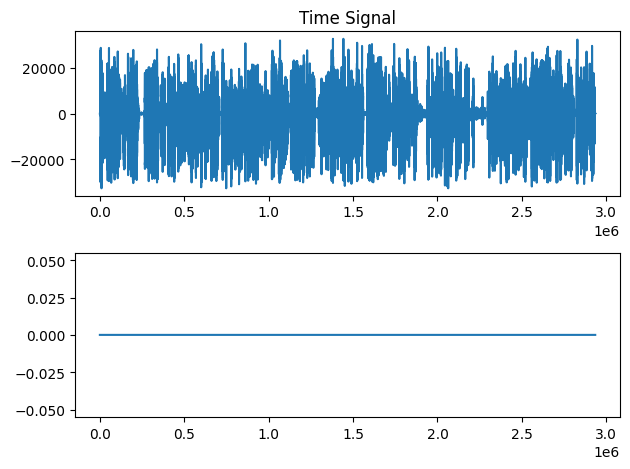

In [32]:
path_clean = '/content/Voice_Data_1.wav'

path_wav = os.path.join(os.getcwd() , path_clean )
(sr, signal) = wav.read(path_wav)

# Ensure correct argument name 'threshold' is passed to the function
vad = VAD(signal, sr, nFFT=512, win_length=0.025, hop_length=0.01, threshold=0.7)

#vad = VAD(signal, sr, nFFT=512, win_length=0.025, hop_length=0.01, threshold=0.6)

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Time Signal')

plt.subplot(2, 1, 2)
plt.plot(vad)


plt.tight_layout()
plt.show()


In [33]:
print(vad[:100])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


**Feature Extraction**

In [34]:
import librosa

# Define the path to your audio file
path_clean = '/content/Voice_Data_1.wav'

# Load the audio file
y, sr = librosa.load(path_clean)

# MFCC feature extraction
mfcc_features = librosa.feature.mfcc(y=y, sr=sr)
print(mfcc_features)

# Zero-crossing rate calculation
zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
print(zero_crossing_rate)

# Spectral Roll-off calculation
S = librosa.magphase(librosa.stft(y))[0]
spectral_rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr)
print(spectral_rolloff)

# Spectral Flux calculation
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
print(onset_env)

# Chroma Feature extraction
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
print(chroma)

# Pitch extraction
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
print(pitches)


[[-515.262 -515.262 -515.262 ... -481.893 -511.961 -514.527]
 [   0.       0.       0.    ...   34.536    3.888    0.671]
 [   0.       0.       0.    ...   10.235    1.955   -0.173]
 ...
 [   0.       0.       0.    ...   -0.179   -0.234   -0.584]
 [   0.       0.       0.    ...   -8.418   -1.271   -0.973]
 [   0.       0.       0.    ...  -13.552   -1.344   -0.672]]
[[0.042 0.118 0.179 ... 0.108 0.103 0.079]]
[[3929.81  3273.047 3251.514 ... 2487.085 2659.351 2648.584]]
[0.    0.    0.    ... 0.486 0.495 0.093]
[[0.011 0.957 0.882 ... 0.556 0.591 0.149]
 [0.    0.481 0.406 ... 0.585 0.509 0.236]
 [0.    0.207 0.311 ... 0.238 0.355 0.2  ]
 ...
 [0.091 0.775 0.937 ... 1.    1.    0.829]
 [1.    0.823 0.966 ... 0.369 0.88  1.   ]
 [0.509 0.892 0.942 ... 0.186 0.488 0.336]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Speaker Identification Using Resemblyzer**

In [35]:
!pip install Resemblyzer
import resemblyzer
from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path
import numpy as np

fpath = Path("/content/Voice_Data_1.wav")
wav = preprocess_wav(fpath)

encoder = VoiceEncoder()
embed = encoder.embed_utterance(wav)
np.set_printoptions(precision=3, suppress=True)
print(embed)

Loaded the voice encoder model on cpu in 0.01 seconds.
[0.018 0.001 0.173 0.    0.005 0.002 0.001 0.005 0.077 0.007 0.042 0.162
 0.023 0.068 0.05  0.    0.07  0.025 0.021 0.158 0.075 0.074 0.    0.
 0.001 0.037 0.011 0.002 0.    0.    0.081 0.089 0.017 0.    0.034 0.107
 0.027 0.008 0.002 0.004 0.    0.039 0.039 0.011 0.015 0.019 0.002 0.005
 0.049 0.006 0.    0.103 0.006 0.    0.    0.008 0.058 0.    0.043 0.039
 0.026 0.029 0.093 0.024 0.037 0.    0.111 0.094 0.    0.013 0.014 0.046
 0.    0.141 0.055 0.02  0.    0.065 0.05  0.121 0.028 0.034 0.105 0.04
 0.    0.002 0.004 0.06  0.    0.163 0.037 0.    0.01  0.    0.    0.
 0.002 0.    0.    0.    0.005 0.    0.084 0.107 0.049 0.022 0.062 0.004
 0.001 0.081 0.    0.027 0.    0.14  0.055 0.    0.075 0.042 0.005 0.002
 0.047 0.092 0.206 0.032 0.054 0.052 0.302 0.108 0.024 0.    0.003 0.001
 0.034 0.068 0.064 0.027 0.052 0.02  0.023 0.048 0.014 0.    0.047 0.034
 0.019 0.001 0.169 0.    0.166 0.038 0.198 0.128 0.    0.011 0.046 0.096
 0.

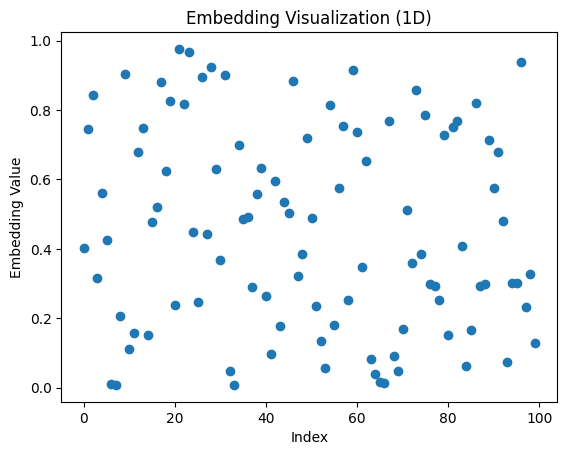

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'embed' is a 1D numpy array
# Example data (replace this with your 'embed' data)
embed = np.random.rand(100)  # Generating random data for demonstration

plt.scatter(range(len(embed)), embed)  # Scatter plot for 1D embedding
plt.title('Embedding Visualization (1D)')
plt.xlabel('Index')
plt.ylabel('Embedding Value')
plt.show()


**Cotnverting list type of "vad" into type"ndarray"**

In [37]:
vad = np.array(vad, dtype='float32')

**Check Array Shapes:** Review the shapes of the arrays involved in the operation, especially those that are being used in calculations or operations. Ensure that their shapes are compatible for the intended operations.

**Investigate the Operation:** Identify the specific operation or line of code where this error occurs. It seems that you're trying to perform an operation that requires broadcasting arrays with incompatible shapes.

**Adjust Shapes or Operations:** If the shapes of the arrays are causing the issue, consider reshaping or adjusting the arrays to make them compatible for the operation you're trying to perform. Alternatively, review the operation to ensure it's correctly handling the shapes of the arrays involved.

In [38]:
# Assuming you have arrays that need to be aligned before concatenation
# For demonstration purposes, let's say vad and embed arrays need alignment
import numpy as np
max_length = len(vad)  # Get the maximum length among the arrays
#print(max_length)

#shape_vad = np.shape(vad)
dimension_vad = np.ndim(vad)
print(dimension_vad)
print(type(vad))

dimension_embed = np.ndim(embed)
print(dimension_embed)
print(type(embed))

dimension_mfcc_features = np.ndim(mfcc_features)
print(dimension_mfcc_features)
print(type(mfcc_features))

dimension_zero_crossing_rate = np.ndim(zero_crossing_rate)
print(dimension_zero_crossing_rate)
print(type(zero_crossing_rate))

dimension_spectral_rolloff = np.ndim(spectral_rolloff)
print(dimension_spectral_rolloff)
print(type(spectral_rolloff))

dimension_onset_env = np.ndim(onset_env)
print(dimension_onset_env)
print(type(onset_env))

dimension_chroma = np.ndim(chroma)
print(dimension_chroma)
print(type(chroma))

dimension_pitches = np.ndim(pitches)
print(dimension_pitches)
print(type(pitches))
print(len(pitches))

"""
# Pad or trim vad array to match max_length
vad = np.pad(vad, ((0, max_length - len(vad)), (0, 0)), mode='constant') if len(vad) < max_length else vad[:max_length]

# Pad or trim embed array to match max_length
embed = np.pad(embed, ((0, max_length - len(embed)), (0, 0)), mode='constant') if len(embed) < max_length else embed[:max_length]
"""

1
<class 'numpy.ndarray'>
1
<class 'numpy.ndarray'>
2
<class 'numpy.ndarray'>
2
<class 'numpy.ndarray'>
2
<class 'numpy.ndarray'>
1
<class 'numpy.ndarray'>
2
<class 'numpy.ndarray'>
2
<class 'numpy.ndarray'>
1025


"\n# Pad or trim vad array to match max_length\nvad = np.pad(vad, ((0, max_length - len(vad)), (0, 0)), mode='constant') if len(vad) < max_length else vad[:max_length]\n\n# Pad or trim embed array to match max_length\nembed = np.pad(embed, ((0, max_length - len(embed)), (0, 0)), mode='constant') if len(embed) < max_length else embed[:max_length]\n"

**Upgrading Features**

In [39]:
import numpy as np

arr = [vad, embed, mfcc_features, zero_crossing_rate, spectral_rolloff, onset_env, chroma, pitches ]
# Assume 'arr' is a list containing NumPy arrays

# Flatten all arrays into 1D arrays and store their shapes
flattened_arrays = [x.flatten() for x in arr]
new_arr = np.concatenate(flattened_arrays)
shapes = [x.shape for x in arr]

# Perform any necessary operations on new_arr here

# Restore the arrays to their original shapes
restoredArray = np.split(new_arr, np.cumsum([np.prod(s) for s in shapes])[:-1])

# Reshape each array in 'restoredArray' to its original shape
restoredArray = [x.reshape(s) for x, s in zip(restoredArray, shapes)]
print(restoredArray)

[array([0., 0., 0., ..., 0., 0., 0.]), array([0.403, 0.744, 0.842, 0.317, 0.562, 0.424, 0.011, 0.008, 0.207,
       0.903, 0.111, 0.156, 0.678, 0.749, 0.151, 0.477, 0.521, 0.881,
       0.623, 0.825, 0.24 , 0.976, 0.816, 0.967, 0.448, 0.247, 0.895,
       0.442, 0.923, 0.63 , 0.367, 0.9  , 0.049, 0.009, 0.699, 0.485,
       0.493, 0.29 , 0.558, 0.634, 0.265, 0.098, 0.596, 0.177, 0.535,
       0.504, 0.885, 0.321, 0.386, 0.721, 0.49 , 0.234, 0.135, 0.056,
       0.813, 0.18 , 0.576, 0.754, 0.254, 0.917, 0.738, 0.349, 0.653,
       0.082, 0.038, 0.015, 0.013, 0.769, 0.092, 0.047, 0.169, 0.512,
       0.358, 0.856, 0.386, 0.786, 0.299, 0.292, 0.252, 0.727, 0.151,
       0.751, 0.768, 0.408, 0.063, 0.167, 0.819, 0.294, 0.299, 0.715,
       0.575, 0.679, 0.481, 0.075, 0.302, 0.301, 0.938, 0.232, 0.327,
       0.129]), array([[-515.262, -515.262, -515.262, ..., -481.893, -511.961, -514.527],
       [   0.   ,    0.   ,    0.   , ...,   34.536,    3.888,    0.671],
       [   0.   ,    0.   ,

In [40]:
# Check the dimensions along the concatenation axis (axis=1 in this case)
for i, arr in enumerate(restoredArray):
    if len(arr.shape) > 1:
        print(f"Array {i} shape along axis 1: {arr.shape[1]}")
    else:
        print(f"Array {i} shape: {arr.shape}")

# Identify the maximum size along axis 1 among the arrays
max_size = max(arr.shape[1] for arr in restoredArray if len(arr.shape) > 1)

# Resize arrays to match the maximum size along axis 1
for i, arr in enumerate(restoredArray):
    if len(arr.shape) > 1:
        curr_size = arr.shape[1]
        if curr_size < max_size:
            # Pad the array to match the maximum size along axis 1
            padding = np.zeros((arr.shape[0], max_size - curr_size))
            restoredArray[i] = np.concatenate((arr, padding), axis=1)

# Now, attempt to concatenate the arrays again
combined_features = np.concatenate([arr for arr in restoredArray if len(arr.shape) > 1], axis=0)


Array 0 shape: (2934720,)
Array 1 shape: (100,)
Array 2 shape along axis 1: 15799
Array 3 shape along axis 1: 15799
Array 4 shape along axis 1: 15799
Array 5 shape: (15799,)
Array 6 shape along axis 1: 15799
Array 7 shape along axis 1: 15799


In [46]:
from sklearn.feature_selection import VarianceThreshold

# Assuming combined_features is your ndarray containing all features
# combined_features shape: (num_samples, num_features)

# Define the threshold for variance
threshold_value = 0.66  # Set your desired threshold value
selector = VarianceThreshold(threshold=threshold_value)

# Fit and transform the data using the selector
selected_features = selector.fit_transform(combined_features)

# Use 'selected_features' for clustering and segmentation
# Apply KMeans clustering or any other segmentation method to 'selected_features'
# Perform segmentation based on the identified clusters


**Clustering and Segmentation**

In [47]:
import numpy as np
from sklearn.cluster import KMeans
import librosa
import soundfile as sf

# Assuming you have the features and variables as described

# Combine different features into a single feature matrix
#combined_features = np.concatenate((vad, embed, mfcc_features, zero_crossing_rate, spectral_rolloff, onset_env, chroma, pitches), axis=1)

# Optionally, perform feature normalization
selected_features_normalized = (selected_features - np.mean(selected_features, axis=0)) / np.std(selected_features, axis=0)

# Apply KMeans clustering
num_clusters = 2  # Change this according to your requirements or using techniques like the elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(selected_features_normalized)

# Initialize empty lists to store segments for each speaker
speaker_segments = [[] for _ in range(num_clusters)]

# Split the data based on clustering results and store segments
for idx, label in enumerate(cluster_labels):
    speaker_segments[label].append(selected_features[idx])

# Save segments for each speaker as separate files (adjust file naming accordingly)
for cluster_id, segments in enumerate(speaker_segments):
    combined_segments = np.concatenate(segments)
    sf.write(f"output_segment_{cluster_id}.wav", combined_segments, sr)  # Save segments for each cluster as a separate WAV file


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# prompt: import numpy as np from sklearn.cluster import KMeans import librosa import soundfile as sf  # Assuming you have the features and variables as described  # Combine different features into a single feature matrix #combined_features = np.concatenate((vad, embed, mfcc_features, zero_crossing_rate, spectral_rolloff, onset_env, chroma, pitches), axis=1)  # Optionally, perform feature normalization combined_features_normalized = (combined_features - np.mean(combined_features, axis=0)) / np.std(combined_features, axis=0)  # Apply KMeans clustering num_clusters = 2  # Change this according to your requirements or using techniques like the elbow method kmeans = KMeans(n_clusters=num_clusters, random_state=42) cluster_labels = kmeans.fit_predict(combined_features_normalized)  # Initialize empty lists to store segments for each speaker speaker_segments = [[] for _ in range(num_clusters)]  # Split the data based on clustering results and store segments for idx, label in enumerate(cluster_labels):     speaker_segments[label].append(combined_features[idx])  # Save segments for each speaker as separate files (adjust file naming accordingly) for cluster_id, segments in enumerate(speaker_segments):     combined_segments = np.concatenate(segments)     sf.write(f"output_segment_{cluster_id}.wav", combined_segments, sr)  # Save segments for each cluster as a separate WAV file, This giving output segments, but  not viving result I required, Kindly Updgrade the code

import numpy as np
from sklearn.cluster import KMeans
import librosa
import soundfile as sf

# Assuming you have the features and variables as described

# Combine different features into a single feature matrix
#combined_features = np.concatenate((vad, embed, mfcc_features, zero_crossing_rate, spectral_rolloff, onset_env, chroma, pitches), axis=1)

# Optionally, perform feature normalization
combined_features_normalized = (combined_features - np.mean(combined_features, axis=0)) / np.std(combined_features, axis=0)

# Apply KMeans clustering
num_clusters = 2  # Change this according to your requirements or using techniques like the elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(combined_features_normalized)

# Initialize empty lists to store segments for each speaker
speaker_segments = [[] for _ in range(num_clusters)]

# Split the data based on clustering results and store segments
for idx, label in enumerate(cluster_labels):
    speaker_segments[label].append(combined_features[idx])

# Save segments for each speaker as separate files (adjust file naming accordingly)
for cluster_id, segments in enumerate(speaker_segments):
    combined_segments = np.concatenate(segments)
    sf.write(f"output_segment_{cluster_id}.wav", combined_segments, sr)  # Save segments for each cluster as a separate WAV file

